In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np

# Import for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import for time series evaluation and splitting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import  GridSearchCV
from sklearn.calibration import LabelEncoder


# Import machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Import advanced time series forecasting
from prophet import Prophet
import pmdarima as pm

# Optional: Set matplotlib inline and seaborn aesthetics
%matplotlib inline
sns.set(style='whitegrid')

In [77]:
# Load the dataset
# Replace 'sales_data.csv' with your actual file path or filename
df = pd.read_csv('./data/ventes_luxe_détaillées.csv', sep=';')


# Display the first few rows of the dataset
print(df.head())

# Check for missing values in each column
print("\nMissing values in each column:")
print(df.isnull().sum())

         Date Catégorie_Produit        Canal_Vente  Événement_Spécial  Mois  \
0  2018-01-01              Mode           En ligne                  0     1   
1  2018-01-01              Mode  Boutique Physique                  0     1   
2  2018-01-01              Mode     Ventes Privées                  0     1   
3  2018-01-01              Mode    Grands Magasins                  0     1   
4  2018-01-01       Accessoires           En ligne                  0     1   

   Année  Montant_Ventes  
0   2018            1207  
1   2018            1134  
2   2018            1224  
3   2018            1325  
4   2018            1123  

Missing values in each column:
Date                 0
Catégorie_Produit    0
Canal_Vente          0
Événement_Spécial    0
Mois                 0
Année                0
Montant_Ventes       0
dtype: int64


In [78]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  # Adjust format if needed

# Ensure 'Mois' and 'Année' match the 'Date' column
df['Mois'] = df['Date'].dt.month
df['Année'] = df['Date'].dt.year

In [79]:
# Encode categorical variables if necessary
# For 'Catégorie_Produit' and 'Canal_Vente', use one-hot encoding
original_df = df.copy()
df = pd.get_dummies(df, columns=['Catégorie_Produit', 'Canal_Vente'], drop_first=True)

# Since 'Événement_Spécial' is an integer, ensure it's treated appropriately
df['Événement_Spécial'] = df['Événement_Spécial'].astype(int)

In [80]:
# Calculate descriptive statistics for 'Montant_Ventes'
sales_stats = df['Montant_Ventes'].describe()
print("Descriptive Statistics for 'Montant_Ventes':")
print(sales_stats)

Descriptive Statistics for 'Montant_Ventes':
count    43824.000000
mean      1190.944939
std        326.263564
min        446.000000
25%        905.000000
50%       1194.000000
75%       1428.000000
max       2559.000000
Name: Montant_Ventes, dtype: float64


# TIME SERIES ANALYSIS

In [81]:
# Set 'Date' as the index and sort the DataFrame by date
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Check for any missing dates in the time series
print("Date range from {} to {}".format(df.index.min(), df.index.max()))
print("Total number of days: {}".format((df.index.max() - df.index.min()).days + 1))
print("Number of observations in data: {}".format(len(df)))

Date range from 2018-01-01 00:00:00 to 2022-12-31 00:00:00
Total number of days: 1826
Number of observations in data: 43824


In [82]:
# Resample the data to monthly frequency and sum 'Montant_Ventes'
monthly_sales = df['Montant_Ventes'].resample('M').sum()
daily_sales = df['Montant_Ventes'].resample('D').sum()

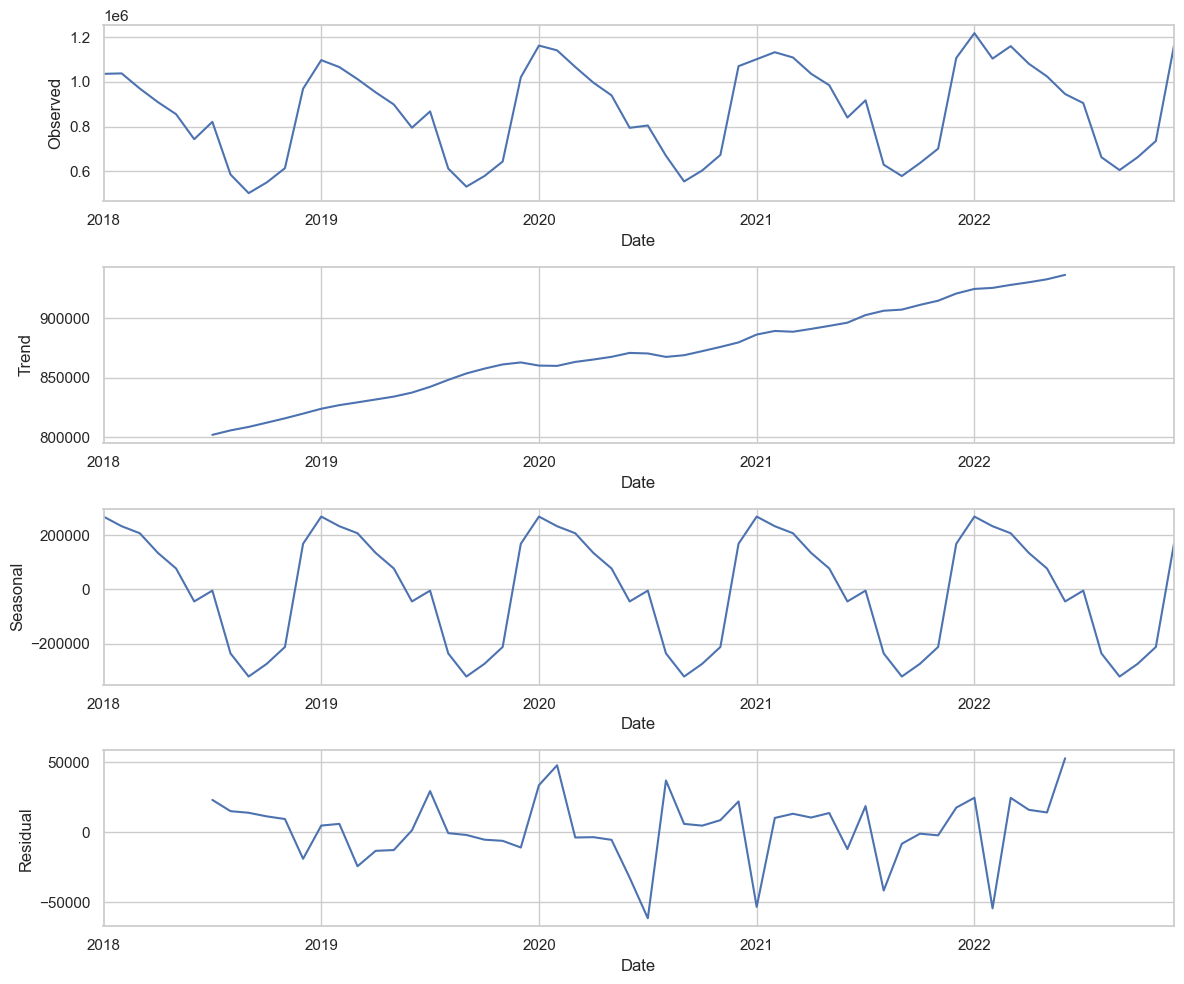

In [83]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

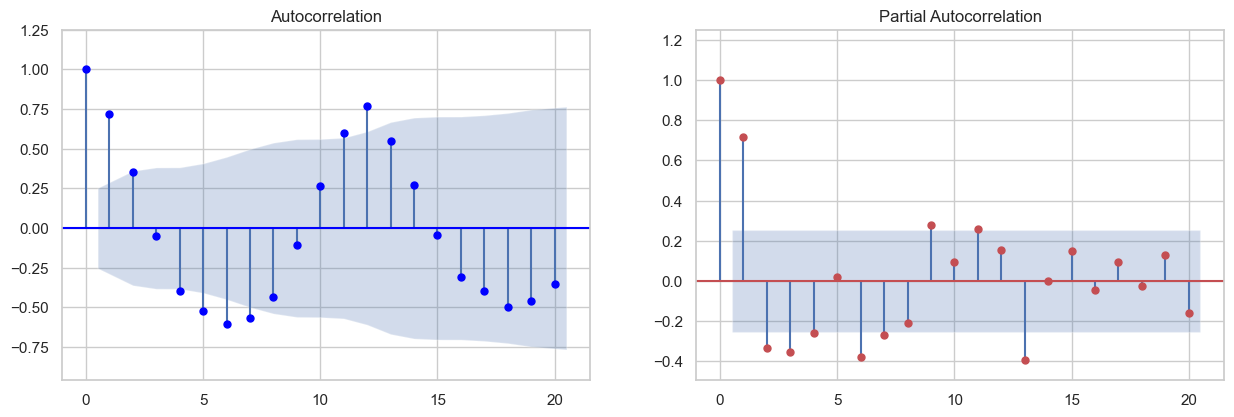

In [84]:
fig = plt.figure(figsize=(15,10))
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
plot_acf(monthly_sales, lags=20,auto_ylims=True, ax=ax2, color="blue")
plot_pacf(monthly_sales, lags=20, method='ywm', auto_ylims=True, ax=ax3, color="r")
plt.show()

In [85]:
# Import the adfuller function
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
adf_result = adfuller(monthly_sales.dropna())

# Extract and display the test results
print('Augmented Dickey-Fuller Test:')
print(f'Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

Augmented Dickey-Fuller Test:
Statistic: -0.4063
p-value: 0.9090
Critical Values:
   1%: -3.5746
   5%: -2.9240
   10%: -2.6000


Statistic (-0.4063) : La statistique du test ADF est beaucoup plus proche de 0, ce qui indique que la série n'est probablement pas stationnaire.

p-value (0.9090) : Avec une p-value de 0.9090, bien supérieure au seuil de signification commun (0.05), nous ne pouvons pas rejeter l'hypothèse nulle. L'hypothèse nulle du test ADF stipule que la série possède une racine unitaire, donc elle n'est pas stationnaire.

#### We need to differenciate the serie because it is not stationna

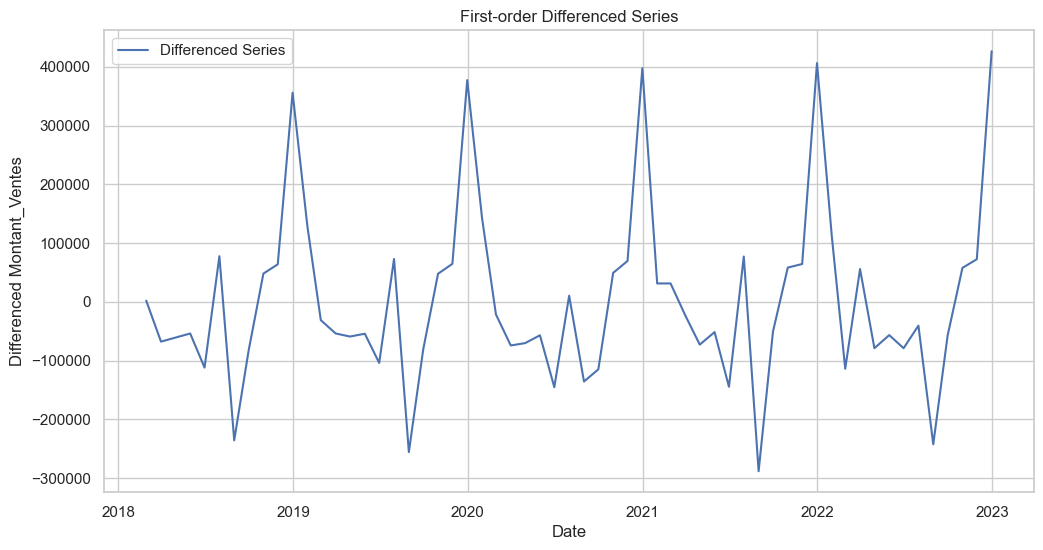

In [86]:
# First-order differencing
monthly_sales_diff = monthly_sales.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_diff, label='Differenced Series')
plt.title('First-order Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Montant_Ventes')
plt.legend()
plt.show()

In [87]:
# Perform ADF test on differenced series
adf_result_diff = adfuller(monthly_sales_diff)

print('ADF Test on Differenced Series:')
print(f'Statistic: {adf_result_diff[0]:.10f}')
print(f'p-value: {adf_result_diff[1]:.10f}')
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print(f'   {key}: {value:.4f}')

ADF Test on Differenced Series:
Statistic: -17.3036035309
p-value: 0.0000000000
Critical Values:
   1%: -3.5746
   5%: -2.9240
   10%: -2.6000


La série 'Montant_Ventes' devient stationnaire après avoir été différenciée, ce qui signifie qu'elle est maintenant appropriée pour l'analyse et la modélisation avec des modèles de séries temporelles tels que ARIMA. Cela suggère que des tendances et des composantes non stationnaires ont été éliminées grâce à la différenciation, rendant la série prête pour des prévisions fiables.

#### The serie need to be deseaosonnalized because it contains seasonal effects

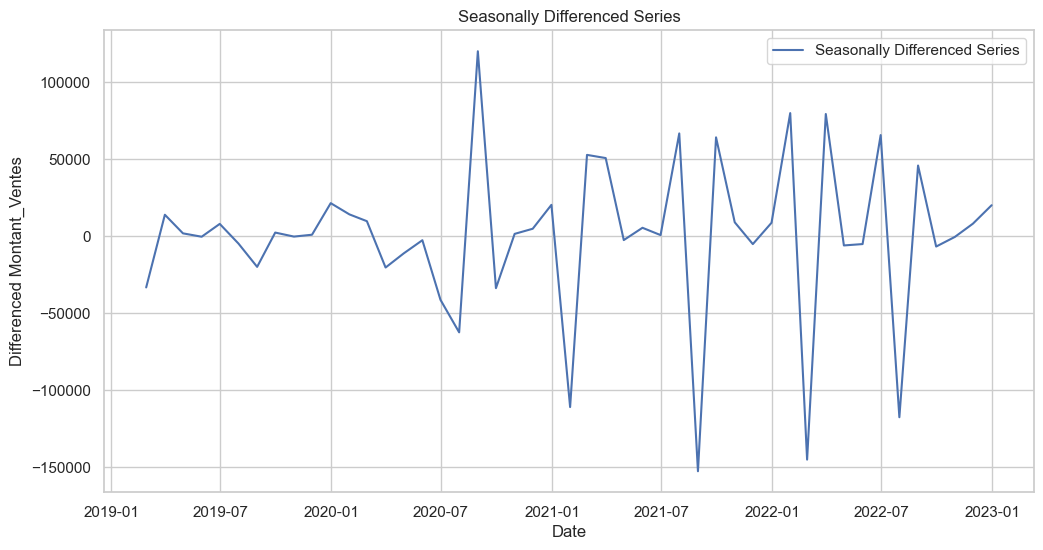

In [88]:
# Seasonal differencing with a lag equal to the seasonal period (12 for monthly data)
monthly_sales_seasonal_diff = monthly_sales_diff.diff(12).dropna()

# Plot the seasonally differenced series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_seasonal_diff, label='Seasonally Differenced Series')
plt.title('Seasonally Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Montant_Ventes')
plt.legend()
plt.show()

In [89]:
# Perform ADF test on seasonally differenced series
adf_result_seasonal_diff = adfuller(monthly_sales_seasonal_diff)

print('ADF Test on Seasonally Differenced Series:')
print(f'Statistic: {adf_result_seasonal_diff[0]:.4f}')
print(f'p-value: {adf_result_seasonal_diff[1]:.4f}')
print('Critical Values:')
for key, value in adf_result_seasonal_diff[4].items():
    print(f'   {key}: {value:.4f}')

ADF Test on Seasonally Differenced Series:
Statistic: -5.7821
p-value: 0.0000
Critical Values:
   1%: -3.6010
   5%: -2.9351
   10%: -2.6060


## ACF & PACF on default data

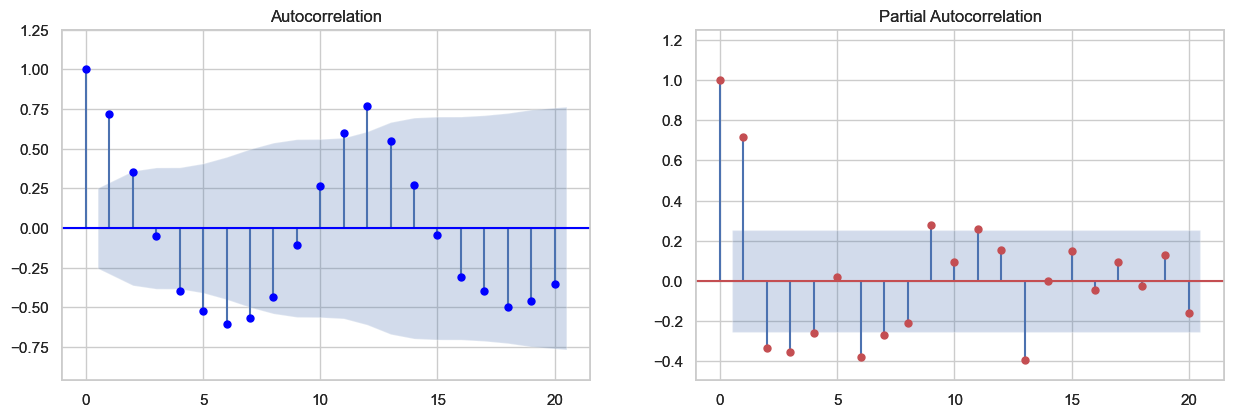

In [90]:
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
plot_acf(monthly_sales, lags=20,auto_ylims=True, ax=ax2, color="blue")
plot_pacf(monthly_sales, lags=20, method='ywm', auto_ylims=True, ax=ax3, color="r")


## ACF & PACF on differencied data

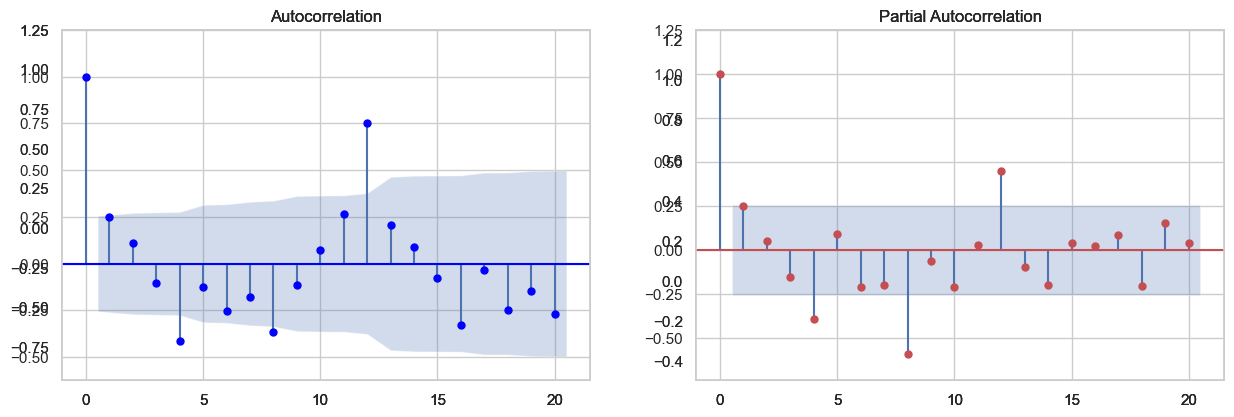

In [91]:
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
plot_acf(monthly_sales_diff, lags=20,auto_ylims=True, ax=ax2, color="blue")
plot_pacf(monthly_sales_diff, lags=20, method='ywm', auto_ylims=True, ax=ax3, color="r")

## ACF & PACF on differencied & deseasonalized data

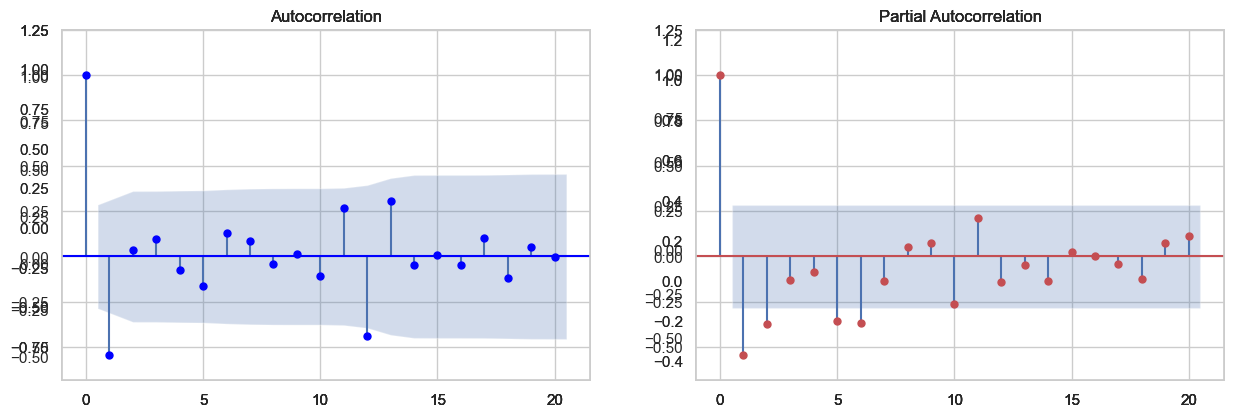

In [92]:
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
plot_acf(monthly_sales_seasonal_diff, lags=20,auto_ylims=True, ax=ax2, color="blue")
plot_pacf(monthly_sales_seasonal_diff, lags=20, method='ywm', auto_ylims=True, ax=ax3, color="r")

# SARIMA & FORECAST

In [93]:
# Define the number of periods to forecast
forecast_periods = 12  # For example, forecast the next 12 months

# Split the data
train_data = monthly_sales.iloc[:-forecast_periods]
test_data = monthly_sales.iloc[-forecast_periods:]

# Print the lengths of the training and test sets
print("Training data length:", len(train_data))
print("Test data length:", len(test_data))

Training data length: 48
Test data length: 12


#### Using auto_arima to intercept good parameters

In [94]:
# Extract the target variable (ensure 'original_df' aligns with 'monthly_sales')
y = original_df['Montant_Ventes']
# Extract exogenous variables and encode them
X = original_df[['Catégorie_Produit', 'Canal_Vente', 'Événement_Spécial']]
X_encoded = pd.get_dummies(X, drop_first=True).astype(float)

X_train = X_encoded.iloc[:-forecast_periods]
X_test = X_encoded.iloc[-forecast_periods:]


# Fit the auto_arima model
model = pm.auto_arima(
    train_data,
    exogenous=X,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    m=12,  # Seasonal period (adjust as necessary)
    seasonal=True,
    d=None,  # Let auto_arima determine the order of differencing
    D=None,
    trace=True,  # Prints the output of the search process
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Set to False to perform an exhaustive search, True for faster search
    n_jobs=-1  # Use all available cores for parallel processing
)

# Get the order and seasonal order from auto_arima
order = model.order
seasonal_order = model.seasonal_order
print("Selected ARIMA order:", order)
print("Selected seasonal order:", seasonal_order)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=855.759, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=858.592, Time=0.06 sec


/Users/mat/Epitech/Digi5_Projects/luxe_retail_eds/.venv/lib/python3.7/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=858.801, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=879.920, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=857.229, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=857.188, Time=0.07 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=859.051, Time=0.20 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=856.925, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=857.116, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=859.110, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.585 seconds
Selected ARIMA order: (0, 0, 0)
Selected seasonal order: (0, 1, 0, 12)
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -425.880
Date:                  Fri, 06 Dec 2024   AIC                            855.759

#### BEST ARIMA FOUND : ARIMA(0,1,1)(0,0,0)[12] 

In [95]:
# Define the SARIMA model
model = SARIMAX(
    train_data,
    exogenous=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
model_fit = model.fit(disp=False)

# Print the summary of the model
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:           Montant_Ventes   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -426.277
Date:                  Fri, 06 Dec 2024   AIC                            854.555
Time:                          16:11:32   BIC                            856.110
Sample:                      01-31-2018   HQIC                           855.092
                           - 12-31-2021                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.636e+09   4.03e+08      4.063      0.000    8.47e+08    2.42e+09
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                15.94
Prob(Q):                       

In [96]:
# Forecast the test data period
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Print forecasted values
print("Forecasted Values:")
print(forecast_mean)

Forecasted Values:
2022-01-31    1101770.0
2022-02-28    1133013.0
2022-03-31    1109439.0
2022-04-30    1036564.0
2022-05-31     985038.0
2022-06-30     840396.0
2022-07-31     917476.0
2022-08-31     629101.0
2022-09-30     578342.0
2022-10-31     636592.0
2022-11-30     700908.0
2022-12-31    1107236.0
Freq: M, Name: predicted_mean, dtype: float64


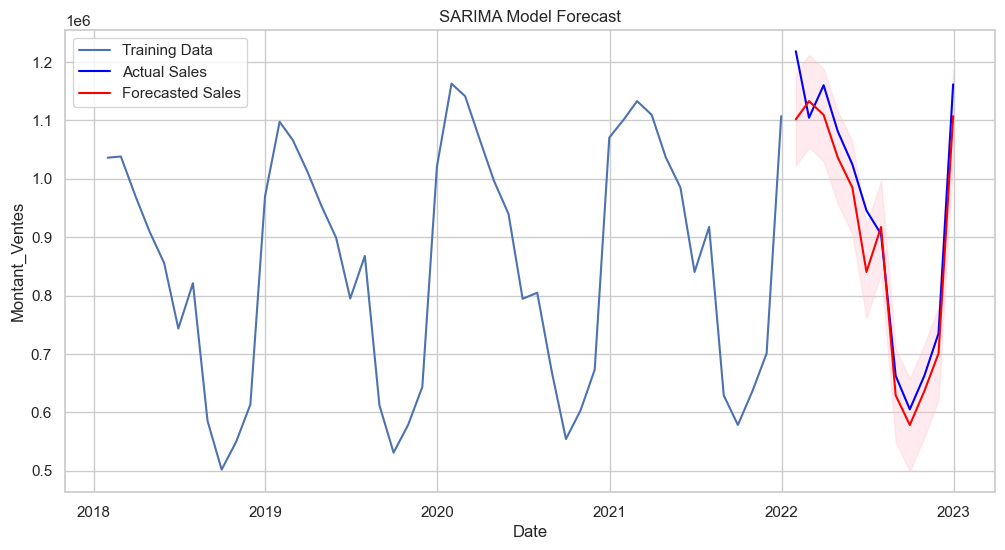

In [97]:
# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Sales', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.legend()
plt.show()

In [98]:
# Calculate mean squared error and root mean squared error
mse = mean_squared_error(test_data, forecast_mean)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Squared Error: 3206539681.25
Root Mean Squared Error: 56626.32


Un RMSE de 56626.32 est relativement élevé par rapport à la moyenne des ventes (environ 1,190), ce qui indique que le modèle présente une certaine marge d'erreur importante dans ses prévisions.

In [99]:
# Forecast future periods (e.g., next 12 months)
future_forecast_periods = 12
future_forecast = model_fit.get_forecast(steps=future_forecast_periods)
future_forecast_mean = future_forecast.predicted_mean
future_forecast_conf_int = future_forecast.conf_int()

# Create date index for future periods
last_date = monthly_sales.index[-1]
future_dates = [last_date + pd.DateOffset(months=x) for x in range(1, future_forecast_periods+1)]
future_forecast_mean.index = future_dates
future_forecast_conf_int.index = future_dates

# Print future forecasted values
print("Future Forecasted Values:")
print(future_forecast_mean)

Future Forecasted Values:
2023-01-31    1101770.0
2023-02-28    1133013.0
2023-03-31    1109439.0
2023-04-30    1036564.0
2023-05-31     985038.0
2023-06-30     840396.0
2023-07-31     917476.0
2023-08-31     629101.0
2023-09-30     578342.0
2023-10-31     636592.0
2023-11-30     700908.0
2023-12-31    1107236.0
Name: predicted_mean, dtype: float64


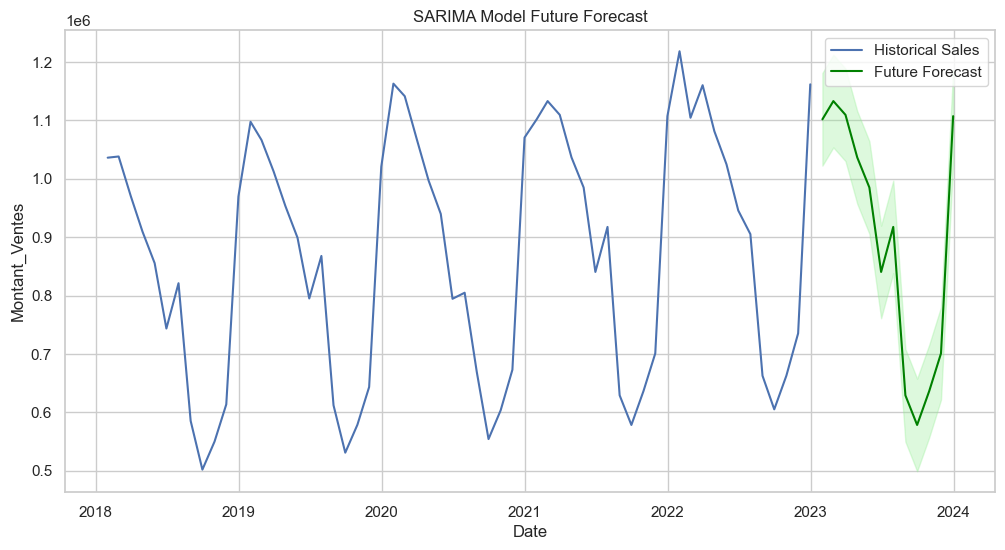

In [100]:
# Plot the historical data and future forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales, label='Historical Sales')
plt.plot(future_forecast_mean.index, future_forecast_mean, label='Future Forecast', color='green')
plt.fill_between(future_forecast_conf_int.index, 
                 future_forecast_conf_int.iloc[:, 0], 
                 future_forecast_conf_int.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA Model Future Forecast')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.legend()
plt.show()

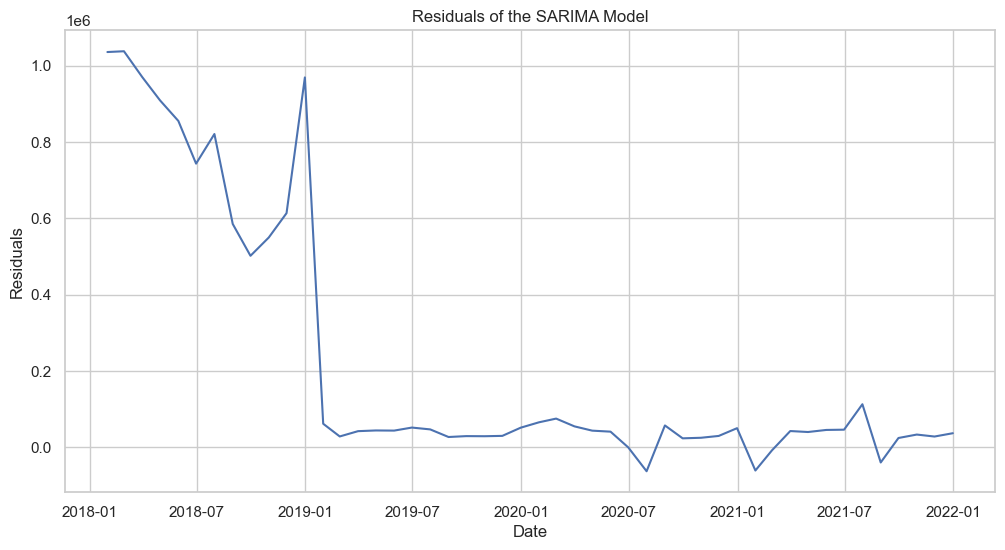

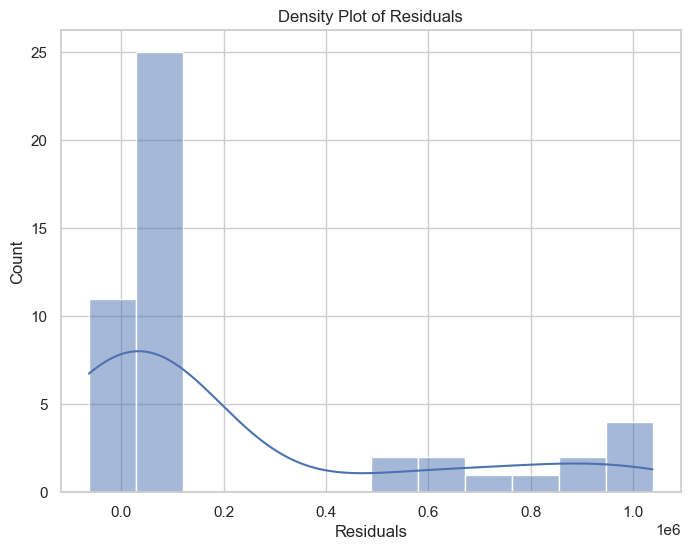

count    4.800000e+01
mean     2.244974e+05
std      3.498136e+05
min     -6.303700e+04
25%      2.900450e+04
50%      4.458950e+04
75%      2.099735e+05
max      1.038151e+06
dtype: float64


In [101]:
# Get the residuals
residuals = model_fit.resid

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot the density of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.show()

print(residuals.describe())

Moyenne non nulle : La moyenne des résidus de 224 497 suggère que les prévisions du modèle ont tendance à être biaisées et à sous-estimer les valeurs réelles des ventes.<br><br>
Écart-type élevé : L'écart-type important montre que les résidus sont dispersés, ce qui peut indiquer des problèmes dans l'ajustement du modèle et la précision des prévisions.<br><br>
Max résiduel élevé : Le résidu maximal de 1,038,151 montre qu'au moins une prévision a significativement sous-estimé la valeur réelle, ce qui peut être le signe d'une anomalie ou d'un événement que le modèle n'a pas bien capturé.<br><br>
Asymétrie de la distribution : La médiane (44 589) étant inférieure à la moyenne (224 497), cela suggère que la distribution des résidus pourrait être biaisée vers la droite, avec quelques grandes valeurs positives influençant la moyenne.

# PROPHET & FORECAST

In [102]:
# Encode categorical variables if using regressors
df = original_df.copy()

df['ds'] = pd.to_datetime(df['Date'])
df['y'] = df['Montant_Ventes']

df['category_encoded'] = df['Catégorie_Produit'].astype('category').cat.codes
df['channel_encoded'] = df['Canal_Vente'].astype('category').cat.codes

# Define holidays/events
holidays = pd.DataFrame({
    'holiday': 'special_event',
    'ds': df[df['Événement_Spécial'] == 1]['ds'],
    'lower_window': 0,
    'upper_window': 1
})

# Initialize the model
model = Prophet(
    growth='linear',
    n_changepoints=30,
    changepoint_range=0.9,
    changepoint_prior_scale=0.1,
    yearly_seasonality=10,
    weekly_seasonality=5,
    seasonality_mode='multiplicative',
    holidays=holidays,
    holidays_prior_scale=20,
    interval_width=0.95
)

# Add regressors if needed
model.add_regressor('category_encoded')
model.add_regressor('channel_encoded')

# Fit the model
model.fit(df)

# # Make future dataframe
future = model.make_future_dataframe(periods=30)  # Forecasting 30 days ahead

16:11:38 - cmdstanpy - INFO - Chain [1] start processing
16:11:44 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
le_category = LabelEncoder()
df['category_encoded'] = le_category.fit_transform(df['Catégorie_Produit'])

le_channel = LabelEncoder()
df['channel_encoded'] = le_channel.fit_transform(df['Canal_Vente'])

# # # Add regressors to future dataframe
future['category_encoded'] = df['category_encoded']
future['channel_encoded'] = df['channel_encoded']
# Predict
forecast = model.predict(future)

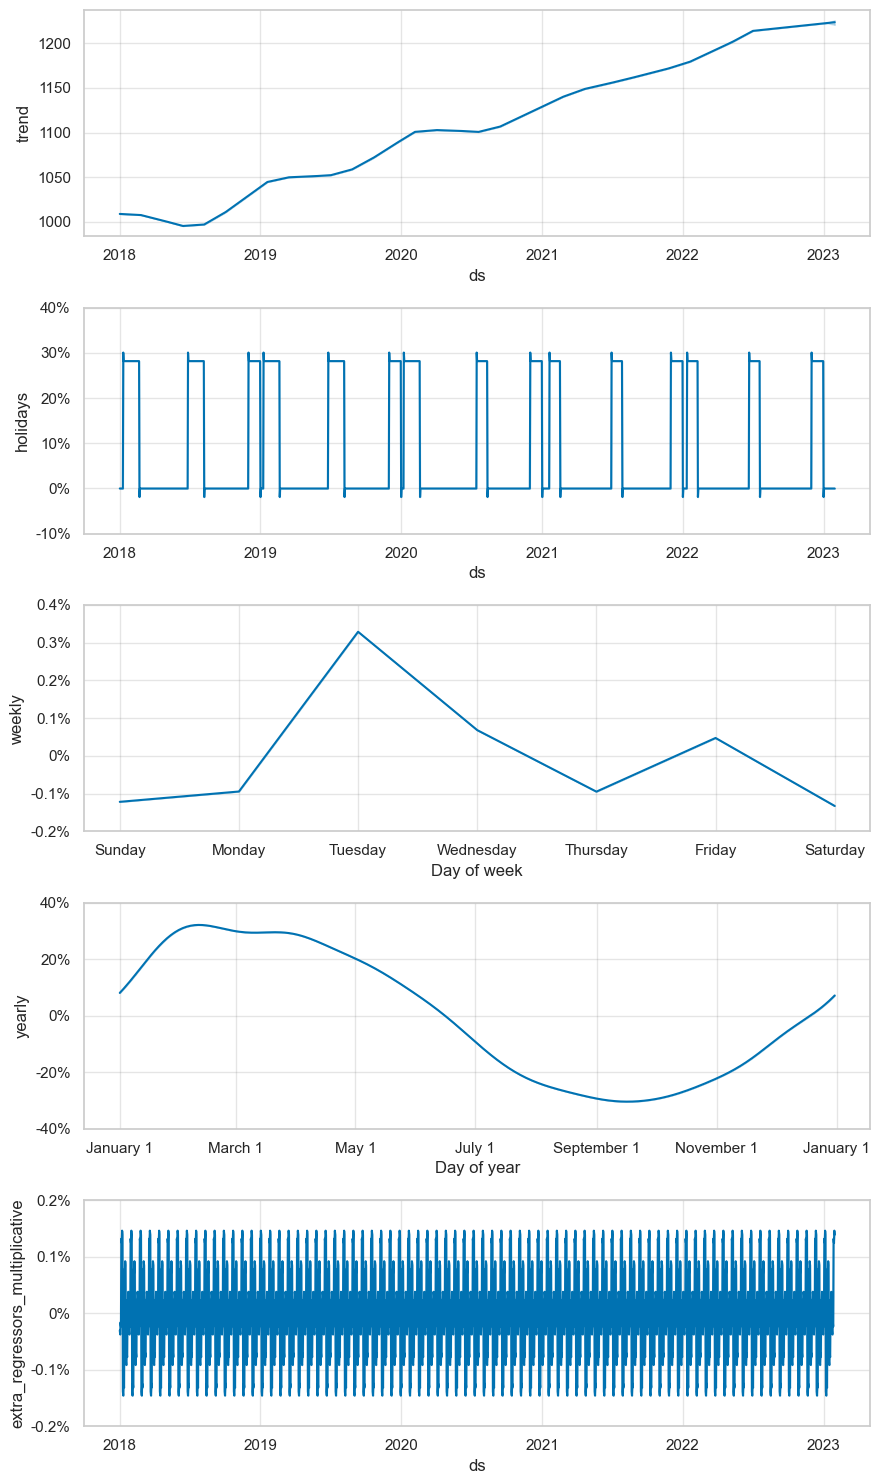

In [104]:
model.plot_components(forecast)
plt.show()

In [105]:
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
}

import itertools
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

for params in all_params:
    model = Prophet(**params).fit(df)
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:11:55 - cmdstanpy - INFO - Chain [1] start processing
16:11:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]16:12:00 - cmdstanpy - INFO - Chain [1] start processing
16:12:01 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:03<00:14,  3.55s/it]16:12:04 - cmdstanpy - INFO - Chain [1] start processing
16:12:05 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:08<00:12,  4.08s/it]16:12:09 - cmdstanpy - INFO - Chain [1] start processing
16:12:10 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:12<00:08,  4.39s/it]16:12:13 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:18<00:04,  4.78s/it]16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:23<00:00,  4.79s/it]
16:12:26 - cmdstanpy - INFO - Chain [1] start processing
16

KeyboardInterrupt: 

# Interpretation
## changepoint_prior_scale Impact:

#### Smaller Values (0.01):

- Lead to a smoother trend with fewer abrupt changes.
The model is less flexible in fitting to noise, reducing the risk of overfitting.
Results in better performance (lower RMSE).

#### Larger Values (0.10 and 0.50):

- Allow the model to fit more closely to short-term fluctuations.
Increase the risk of overfitting to noise in the data.
Result in worse performance (higher RMSE).

#### Conclusion: 
Your data benefits from a less flexible trend component, **suggesting that the underlying trend is relatively stable without abrupt changes.**

## seasonality_prior_scale Impact:

Changes in seasonality_prior_scale have a minor effect on RMSE.
This indicates that the model's performance is less sensitive to the flexibility of the seasonal components.

#### Possible Reasons:
Seasonal patterns in your data are well-captured even with default settings.
The seasonal effects may not be highly complex, so increasing flexibility doesn't significantly improve the fit.

#### Conclusion: 
Adjusting seasonality_prior_scale within the tested range doesn't substantially affect model performance.

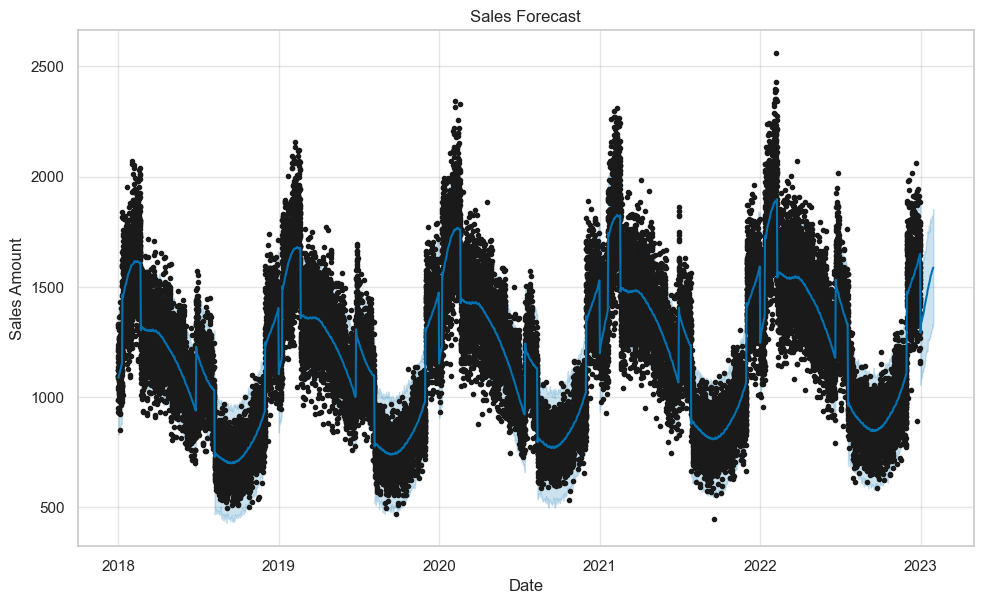

In [ ]:
fig1 = model.plot(forecast)
ax = fig1.gca()
ax.set_title('Sales Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
plt.show()

# MACHINE LEARNING

In [ ]:
df = original_df.copy()

# Encode 'Événement_Spécial' as categorical if it's an integer code
df['Événement_Spécial'] = df['Événement_Spécial'].astype(int)

# Create dummy variables for 'Événement_Spécial'
df = pd.get_dummies(df, columns=['Catégorie_Produit', 'Canal_Vente'], drop_first=True)


In [ ]:
# Extract additional time features
df.reset_index(inplace=True)
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
# Sort the DataFrame by 'Date'
df.sort_values('Date', inplace=True)

# Create lag features (e.g., previous day's sales)
df['Lag_1'] = df['Montant_Ventes'].shift(1)
df['Lag_2'] = df['Montant_Ventes'].shift(2)
df['Lag_3'] = df['Montant_Ventes'].shift(3)

# Drop rows with NaN values resulting from lag features
df_ml = df.dropna()

In [ ]:
# Define the target variable and features
target = 'Montant_Ventes'

# Drop columns that are not features
drop_cols = ['Date', 'Montant_Ventes', 'Mois', 'Année']

# Features include all columns except those in 'drop_cols'
X = df_ml.drop(columns=drop_cols)
y = df_ml[target]

# Check the shape of features and target
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Use the last 20% of data for testing
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Features shape: (43821, 17)
Target shape: (43821,)
Training set size: (35056, 17)
Test set size: (8765, 17)


In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

In [ ]:
# Decision Tree Regression
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

In [ ]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

In [ ]:

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  R-squared (R²): {r2:.2f}")
    print("-" * 50)

# Evaluate all models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_dt, "Decision Tree Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regression")

Linear Regression Performance:
  Mean Absolute Error (MAE): 115.93
  Mean Squared Error (MSE): 22120.39
  Root Mean Squared Error (RMSE): 148.73
  R-squared (R²): 0.81
--------------------------------------------------
Decision Tree Regression Performance:
  Mean Absolute Error (MAE): 184.36
  Mean Squared Error (MSE): 54634.13
  Root Mean Squared Error (RMSE): 233.74
  R-squared (R²): 0.52
--------------------------------------------------
Random Forest Regression Performance:
  Mean Absolute Error (MAE): 117.39
  Mean Squared Error (MSE): 22675.52
  Root Mean Squared Error (RMSE): 150.58
  R-squared (R²): 0.80
--------------------------------------------------
Gradient Boosting Regression Performance:
  Mean Absolute Error (MAE): 114.47
  Mean Squared Error (MSE): 21324.81
  Root Mean Squared Error (RMSE): 146.03
  R-squared (R²): 0.81
--------------------------------------------------


Le Gradient Boosting Regression semble être le modèle le plus performant, avec un MAE et un RMSE plus faibles, tout en gardant un R-squared élevé. Cela signifie qu'il a une bonne capacité à généraliser tout en capturant des relations complexes dans les données.<br><br>
La régression linéaire et le Random Forest offrent également de bonnes performances et peuvent être de bons choix pour des prévisions plus simples ou pour limiter la complexité computationnelle.<br><br>
Le Decision Tree Regression est moins performant, avec des erreurs plus élevées et un R-squared nettement plus bas, ce qui en fait un choix moins adapté pour ce type de données.

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator
best_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the tuned model
evaluate_model(y_test, y_pred_best_rf, "Random Forest Regression (Tuned)")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.7s
[CV] END max_dept

#### Le modèle Random Forest a été optimisé avec GridSearchCV et donne les résultats suivants :
<br>
MSE : 23648.65 → Moyenne des erreurs au carré, dépend de l'échelle de la variable cible.<br>
RMSE : 153.78 → Écart moyen entre les prédictions et les valeurs réelles.<br>
R² : 0.79 → Le modèle explique 79 % de la variance des données.<br><br>
Globalement, c'est un bon modèle,

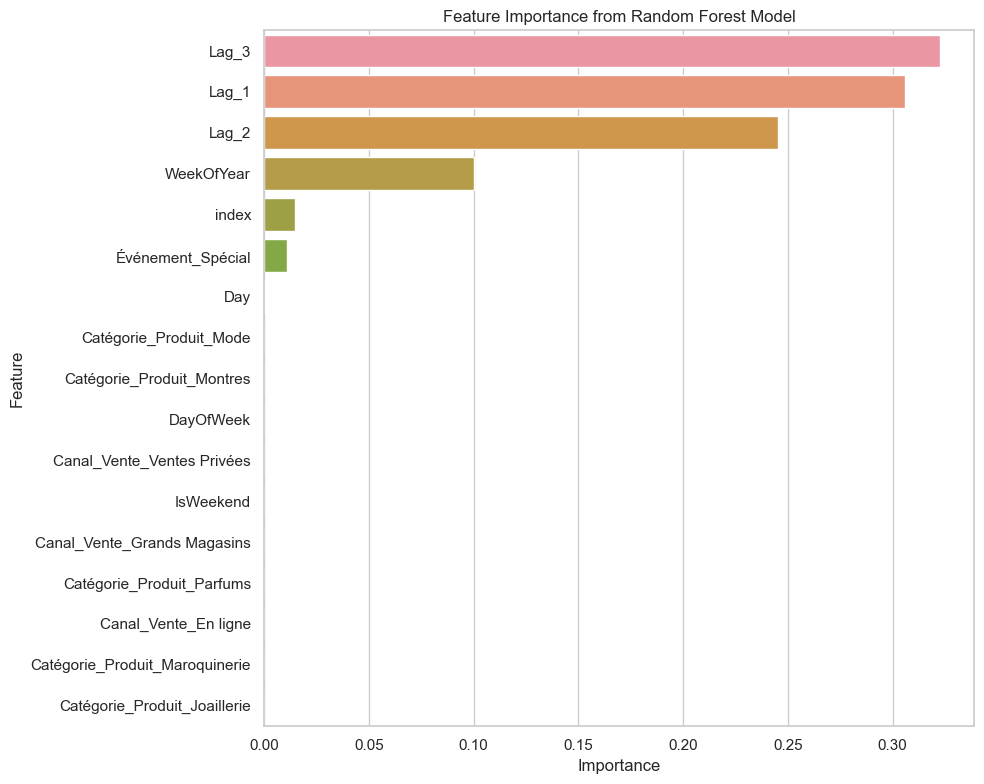

In [ ]:
# For the best Random Forest model
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

#### Lag_1 (0.383009), Lag_3 (0.301348), et Lag_2 (0.192162) : Les variables de retard (lags) sont les plus influentes, représentant des ventes des périodes précédentes. Cela indique que la série temporelle a une forte dépendance à ses valeurs passées, soulignant l'importance de la continuité temporelle dans les prévisions.<br><br> Les caractéristiques de retard (lags) et la saisonnalité annuelle (WeekOfYear) sont les facteurs les plus déterminants pour la prédiction des ventes dans ce dataset. Les caractéristiques telles que le jour de la semaine, les catégories de produits, et les canaux de vente semblent avoir un impact négligeable sur la performance du modèle.<br><br> Cela pourrait indiquer que l'historique des ventes et la saisonnalité annuelle expliquent la majeure partie de la variation des ventes, tandis que les autres variables n'apportent pas de valeur ajoutée significative.

D'après la matrice de corrélation du départ, on voit une forte liaison entre le mois de l'année et le montant des ventes.

Cela est confirmé par graph "Feature Importance from Random Forest Model" qui indique qu'en plus des LAG, la donnée influençante la plus importante est "WeekOfMonth"


In [ ]:
import joblib

# Save the best model
joblib.dump(best_rf_model, 'best_rf_model.pkl')